In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import os

In [18]:
import os

# Paths to your dataset directories
train_dir = 'C:/Users/sunka/Desktop/activity-recog/dataset-resized-r2/dataset-resized-r2/r2_train'
test_dir = 'C:/Users/sunka/Desktop/activity-recog/dataset-resized-r2/dataset-resized-r2/r2_test'

# Checking weather there are videos and count of the videos present in the dataset
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        print(f"Class '{class_name}' has {len(os.listdir(class_path))} videos.")


Class 'Eating' has 51 videos.
Class 'EVS Visit' has 51 videos.
Class 'Family visit' has 51 videos.
Class 'Lying in bed' has 51 videos.
Class 'Nurse-Doctor visit' has 51 videos.
Class 'Resting' has 51 videos.
Class 'Sitting in wheelchair' has 51 videos.
Class 'Talking on phone' has 51 videos.
Class 'Therapy' has 51 videos.
Class 'Watching TV' has 51 videos.


In [28]:
import os
from torch.utils.data import DataLoader, Dataset
import torch
import numpy as np
import cv2
from torchvision import transforms
import torch.nn as nn
from torchvision import models
import torch.optim as optim

class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_frames=16, top_k=5, num_classes=10):
        self.root_dir = root_dir
        self.transform = transform
        self.num_frames = num_frames
        self.num_classes = num_classes  # Move this before calling _load_top_k_videos
        self.video_paths, self.labels = self._load_top_k_videos(top_k)

    def _load_top_k_videos(self, top_k):
        video_paths = []
        labels = []
        class_folders = sorted(os.listdir(self.root_dir))
        for label, class_name in enumerate(class_folders):
            if label < self.num_classes:  # Only consider classes up to num_classes
                class_dir = os.path.join(self.root_dir, class_name)
                if os.path.isdir(class_dir):
                    videos = sorted(os.listdir(class_dir))[:top_k]  # Select top K videos
                    for video in videos:
                        video_paths.append(os.path.join(class_dir, video))
                        labels.append(label)  # Label should be 0-9 for 10 classes
        return video_paths, labels

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]
        frames = self._load_video_frames(video_path, self.num_frames)

        if self.transform:
            frames = [self.transform(frame) for frame in frames]
        frames = torch.stack(frames)  # Shape: (num_frames, C, H, W)
        return frames, label

    def _load_video_frames(self, video_path, num_frames):
        frames = []
        cap = cv2.VideoCapture(video_path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        if frame_count <= 0:
            print(f"Warning: Unable to read frames from {video_path}")
            cap.release()
            return [np.zeros((224, 224, 3), dtype=np.uint8) for _ in range(num_frames)]
        
        sample_indices = np.linspace(0, frame_count - 1, num_frames).astype(int)

        for idx in sample_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
            else:
                frames.append(np.zeros((224, 224, 3), dtype=np.uint8) if frames else np.zeros((224, 224, 3), dtype=np.uint8))
        cap.release()

        if len(frames) == 0:
            frames = [np.zeros((224, 224, 3), dtype=np.uint8) for _ in range(num_frames)]

        return frames

class ResNetVideoClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetVideoClassifier, self).__init__()
        # Load a pretrained ResNet model
        self.resnet = models.resnet50(pretrained=True)
        
        # Modify the final fully connected layer to match the number of video classes
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)
        
        for name, param in self.resnet.named_parameters():
            if 'layer4' not in name:  # Freezed all layers except the last block
                param.requires_grad = False

    def forward(self, x):
        # Input x is expected to be of shape (batch, num_frames, C, H, W)
        batch_size, num_frames, C, H, W = x.shape
        x = x.view(batch_size * num_frames, C, H, W)  # Flatten frames into batch dimension
        
        x = self.resnet(x)  # Shape: (batch_size * num_frames, num_classes)
        x = x.view(batch_size, num_frames, -1)  # Reshape to (batch, num_frames, num_classes)
        x = x.mean(dim=1)  # Average the predictions across frames
        return x

# Data transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define number of classes
num_classes = 10  # Adjust to match the number of classes in your dataset

# Initialize dataset with only the top 5 videos per class
train_dataset = VideoDataset(train_dir, transform=transform, num_classes=num_classes)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Define loss function and optimizer
model = ResNetVideoClassifier(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")


Epoch 1/10, Loss: 2.4680116954057114
Epoch 2/10, Loss: 1.8076157155244246
Epoch 3/10, Loss: 1.9874922192615012
Epoch 4/10, Loss: 1.5011113467423811
Epoch 5/10, Loss: 1.5332919307377026
Epoch 6/10, Loss: 1.27937105168467
Epoch 7/10, Loss: 0.9639973258194716
Epoch 8/10, Loss: 1.0071495732535487
Epoch 9/10, Loss: 1.0243946300900502
Epoch 10/10, Loss: 0.955044585077659


In [29]:
# Evaluation function
def evaluate(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for inputs, labels in test_loader:
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            running_loss += loss.item()

            # Get the predicted class
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct_predictions / total_predictions
    return avg_loss, accuracy

# Initialize the test dataset and loader
test_dataset = VideoDataset(test_dir, transform=transform, num_classes=num_classes)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Evaluate the model on test data
test_loss, test_accuracy = evaluate(model, test_loader, criterion)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 3.1687
Test Accuracy: 28.89%


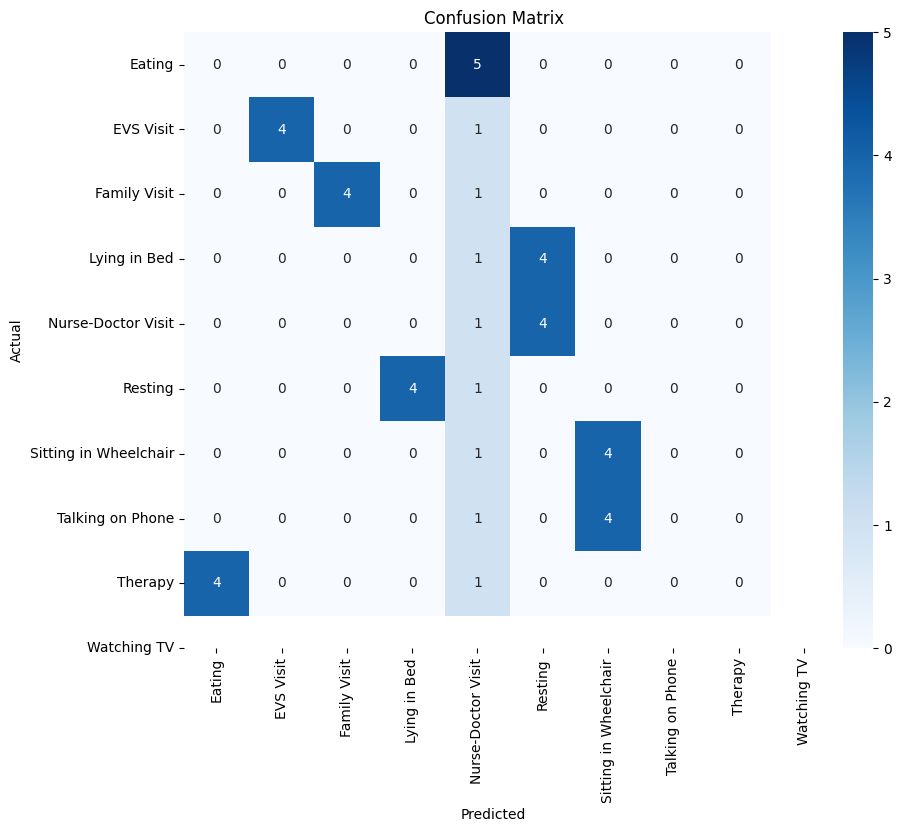

In [37]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, preds, classes):
    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model and plot the confusion matrix
def evaluate_with_confusion_matrix(model, test_loader, num_classes):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation for evaluation
        for inputs, labels in test_loader:
            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Plot confusion matrix using the provided function
    class_names = ['Eating','EVS Visit','Family Visit','Lying in Bed','Nurse-Doctor Visit','Resting','Sitting in Wheelchair','Talking on Phone','Therapy','Watching TV']
    plot_confusion_matrix(all_labels, all_preds, classes=class_names)

# Example usage (make sure to replace 'test_loader' and 'model' with your actual test loader and trained model)
evaluate_with_confusion_matrix(model, test_loader, num_classes)
